## Volume

In [1]:
using Revise, LazySets, BenchmarkTools

In [2]:
X = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.4277185365984995, -0.5958237211401307], [0.7362642865059505, 0.18876664923155967])

In [3]:
using Plots

In [4]:
r = radius_hyperrectangle(X)

2-element Array{Float64,1}:
 0.7362642865059505 
 0.18876664923155967

In [27]:
import Polyhedra: volume # if polyhedra is loaded

function volume(X::AbstractHyperrectangle)
    r = radius_hyperrectangle(X)
    n = LazySets.dim(X)
    α = exp(n*log(2))
    vol = α * prod(r)
    return vol
end

function volume2(X::AbstractHyperrectangle)
    q = 2 .* radius_hyperrectangle(X)
    return prod(q)
end

volume2 (generic function with 1 method)

In [6]:
B = BallInf(zeros(Rational{Int}, 3), 1//1)
volume2(B)

8//1

In [7]:
@btime volume($B)

  97.191 ns (1 allocation: 128 bytes)


7.999999999999998

In [8]:
@btime volume2($B)

  178.314 ns (2 allocations: 256 bytes)


8//1

## Iterative scheme

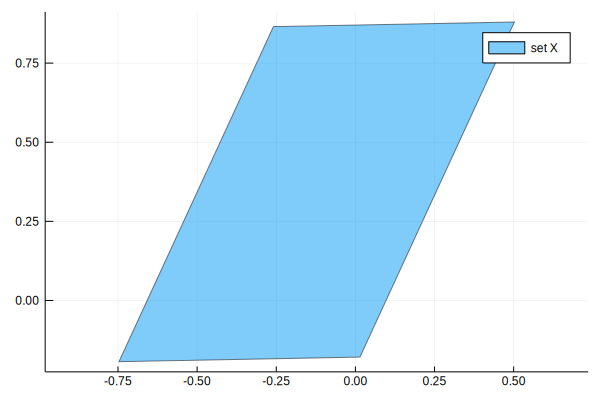

In [9]:
X = rand(Zonotope)
plot(X, ratio=1., lab="set X")

In [10]:
H = overapproximate(X, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.12228877918355896, 0.34324841110709126], [0.624699964774164, 0.5365677823878285])

In [11]:
vol = volume(H)

1.340775499026511

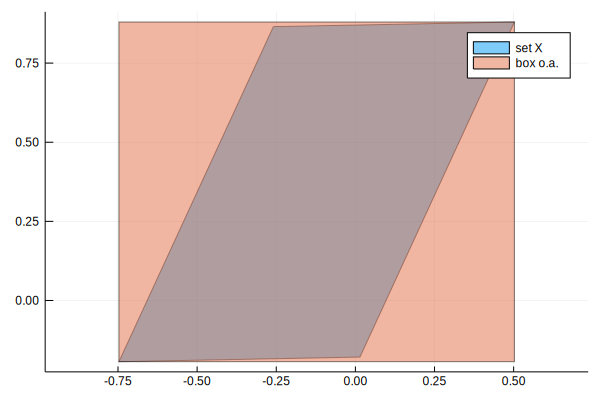

In [12]:
plot!(H, lab="box o.a.")

In [13]:
partition = fill(2, dim(H))
Hsplit = split(H, partition)

4-element Array{Hyperrectangle{Float64,VNC,VNR} where VNR<:AbstractArray{Float64,1} where VNC<:AbstractArray{Float64,1},1}:
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.43463876157064096, 0.07496451991317699], [0.312349982387082, 0.26828389119391427])
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.19006120320352304, 0.07496451991317699], [0.312349982387082, 0.26828389119391427]) 
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.43463876157064096, 0.6115323023010055], [0.312349982387082, 0.26828389119391427]) 
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.19006120320352304, 0.6115323023010055], [0.312349982387082, 0.26828389119391427])  

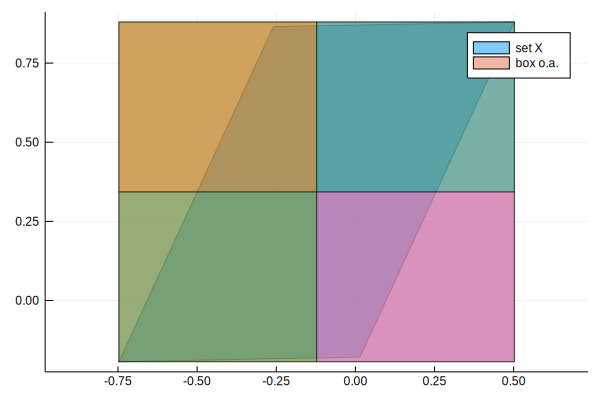

In [14]:
plot!([x for x in Hsplit])

In [15]:
is_intersection_empty(Hsplit[1], X)

false

In [16]:
@btime is_intersection_empty($Hsplit[1], $X)

  26.410 μs (202 allocations: 28.86 KiB)


false

In [17]:
# this problem is implemented by solving a feasibility LP
# GLPK is being used as the LP solver. there exist faster solvers
# (some of them are commercial but we can use an academic license) 
@which is_intersection_empty(Hsplit[1], X)

is_intersection_empty(P::AbstractPolyhedron{N}, Q::AbstractPolyhedron{N}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/ConcreteOperations/isdisjoint.jl:986

In [18]:
# discard elements with empty intersection
for k in eachindex(Hsplit)
    empty_intersection = is_intersection_empty(Hsplit[k], X)
    if empty_intersection
        # discard this element
        println("discarding element $k")
        deleteat!(Hsplit, k)
    end
end
Hsplit

4-element Array{Hyperrectangle{Float64,VNC,VNR} where VNR<:AbstractArray{Float64,1} where VNC<:AbstractArray{Float64,1},1}:
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.43463876157064096, 0.07496451991317699], [0.312349982387082, 0.26828389119391427])
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.19006120320352304, 0.07496451991317699], [0.312349982387082, 0.26828389119391427]) 
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.43463876157064096, 0.6115323023010055], [0.312349982387082, 0.26828389119391427]) 
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.19006120320352304, 0.6115323023010055], [0.312349982387082, 0.26828389119391427])  

In this case nothing is discarded. Now we split again: for each hyperrectangle in `Hsplit` we have to split into four hyperrectangles.

In [19]:
Hsplit_next = split(Hsplit[1], partition)

4-element Array{Hyperrectangle{Float64,VNC,VNR} where VNR<:AbstractArray{Float64,1} where VNC<:AbstractArray{Float64,1},1}:
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.5908137527641819, -0.05917742568378015], [0.156174991193541, 0.13414194559695714])
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.2784637703770999, -0.05917742568378015], [0.156174991193541, 0.13414194559695714])
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.5908137527641819, 0.20910646551013412], [0.156174991193541, 0.13414194559695714]) 
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.2784637703770999, 0.20910646551013412], [0.156174991193541, 0.13414194559695714]) 

In [20]:
partition

2-element Array{Int64,1}:
 2
 2

In [21]:
prod(partition)

4

In [22]:
# now we bisect all elements in the waiting list 
α = prod(partition)
N = length(Hsplit) # length of Hsplit in the current iteration
println("N = $N")
for i in 1:N
    μ = α * (i-1)
    Hsplit_i = split(Hsplit[1 + μ], partition)
    deleteat!(Hsplit, 1 + μ)
    for (k, x) in enumerate(Hsplit_i)
        insert!(Hsplit, k + μ, x)
    end
end
length(Hsplit)

N = 4


16

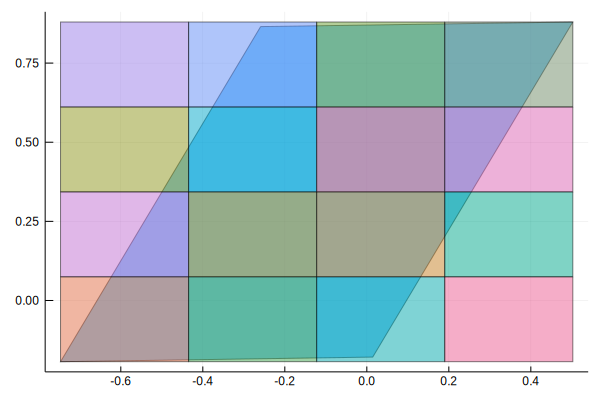

In [23]:
plot(X)
plot!([x for x in Hsplit])

The iterative scheme continues by discarding the boxes which do not intersect, and also the boxes which are strictly inside the set.

In [24]:
vol = 0.0

println("length before discarding elements: $(length(Hsplit))")

# discard elements with empty intersection
removed_sets = []
for k in eachindex(Hsplit)
    Hk = Hsplit[k]
    empty_intersection = is_intersection_empty(Hk, X)
    if empty_intersection
        # discard this element
        println("discarding element $k with empty intersection")
        #deleteat!(Hsplit, k)
        push!(removed_sets, k)
    elseif Hk ⊆ X
        vol += volume(Hk)
        println("discarding element $k contained in X")
        #deleteat!(Hsplit, k)
        push!(removed_sets, k)
    else
        # over-estimation of the volume by adding the volume of the boxes
        # that partially intersect X
        vol += volume(Hk)
    end
end
deleteat!(Hsplit, removed_sets)
println("length after discarding elements: $(length(Hsplit))")

length before discarding elements: 16
discarding element 4 contained in X
discarding element 6 with empty intersection
discarding element 11 with empty intersection
discarding element 13 contained in X
length after discarding elements: 12


In [25]:
v = [1, 2, 3, 4]
deleteat!(v, [1, 3])

2-element Array{Int64,1}:
 2
 4

In [26]:
vol

1.1731785616481971

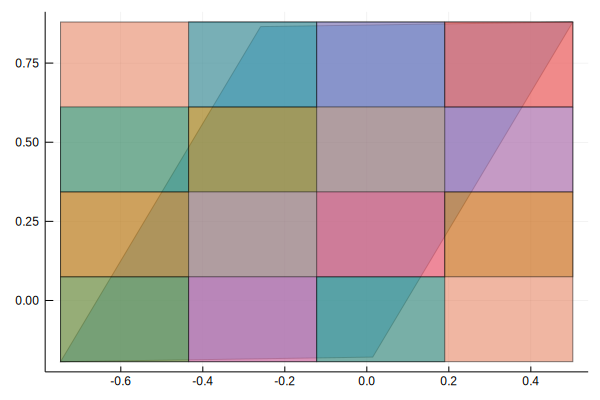

In [27]:
plot(X)
plot!(H)
plot!([x for x in Hsplit])

The iterative scheme now splits again each set and continues, giving a tighter approximation of the volume.

## Algorithm

In [28]:
using Revise, LazySets, Plots

In [29]:
vol = Vector{Tuple{Float64, Float64}}()
push!(vol, (1.0, 2.))

1-element Array{Tuple{Float64,Float64},1}:
 (1.0, 2.0)

In [30]:
# this function is now LazySets#1806
function _volume(X::LazySet{N}; partition=fill(2, dim(X)), tol=1e-2, itermax=5,
                 inclusion_check_algorithm::String="constraints",
                 disjointness_check_algorithm::String="exact") where {N}

    # initial box overapproximation
    H = overapproximate(X, Hyperrectangle)

    # if X is box-shaped, its volume is that of H
    if issubset(H, X, algorithm=inclusion_check_algorithm)
        return volume(H)
    end
    
    # sequence of inner and outer volume computations
    vol_inner = Vector{N}()
    vol_outer = Vector{N}()

    # initial splitting
    Hsplit = split(H, partition)
    α = prod(partition)

    # iterative splitting
    k = 1
    while k <= itermax
        #println("iteration $k")
        #println("number of elements in the list $(length(Hsplit))")
        discard_and_evaluate!(Hsplit, vol_inner, vol_outer, X, inclusion_check_algorithm, disjointness_check_algorithm)
        bisect!(Hsplit, partition, α)
        if k >= 2 && (last(vol_outer) + vol_inner[end] - vol_inner[end-1] < tol)
            break
        end
        k += 1
    end

    return sum(vol_inner) + last(vol_outer)
end

# discard boxes which either are totally outside X, or totally inside X
# we also evaluate the volume for the inner boxes, and for the boxes whose intersection
# with X is non-empty but are not contained
function discard_and_evaluate!(Hsplit, vol_inner::Vector{N}, vol_outer::Vector{N}, X,
                               inclusion_check_algorithm,
                               disjointness_check_algorithm) where {N}
    vol_inner_iter = zero(N)
    vol_outer_iter = zero(N)
    delete_idx = Vector{Int}()
    for k in eachindex(Hsplit)
        Hk = Hsplit[k]
        if isdisjoint(Hk, X, algorithm=disjointness_check_algorithm)
            # discard this element
            push!(delete_idx, k)
        elseif issubset(H, X, algorithm=inclusion_check_algorithm)
            # accumulate volume and discard this element 
            vol_inner_iter += volume(Hk)
            push!(delete_idx, k)
        else
            # volume over-estimation by adding the volume of the boxes partially intersecting X
            vol_outer_iter += volume(Hk)
        end
    end
    deleteat!(Hsplit, delete_idx)
    push!(vol_inner, vol_inner_iter)
    push!(vol_outer, vol_outer_iter)
end

# bisect all elements in the waiting list 
function bisect!(Hsplit, partition, α)
    # length of Hsplit for the current iteration
    N = length(Hsplit)
    for i in 1:N
        μ = α * (i-1)
        Hi = split(Hsplit[1 + μ], partition)
        deleteat!(Hsplit, 1 + μ)
        for (k, x) in enumerate(Hi)
            insert!(Hsplit, k + μ, x)
        end
    end
end

bisect! (generic function with 1 method)

### Example

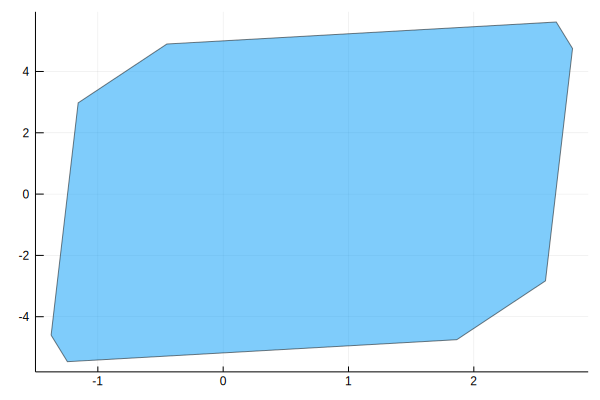

In [39]:
X = rand(Zonotope)
plot(X)

In [40]:
H = overapproximate(X, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.7074356192801613, 0.07351559642557949], [2.0802907297423445, 5.540445605443434])

In [41]:
[4^i for i in 1:10]

10-element Array{Int64,1}:
       4
      16
      64
     256
    1024
    4096
   16384
   65536
  262144
 1048576

### Breaking with the tolerance

In [42]:
vol = _volume(X, itermax=100, tol=1.0)

InterruptException: InterruptException:

In [107]:
vol = _volume(X, itermax=100, tol=0.05)

iteration 1
number of elements in the list 4
iteration 2
number of elements in the list 16
iteration 3
number of elements in the list 48
iteration 4
number of elements in the list 112
iteration 5
number of elements in the list 240
iteration 6
number of elements in the list 496
iteration 7
number of elements in the list 1008
iteration 8
number of elements in the list 2032


4.284464250907463

In [108]:
vol = _volume(X, itermax=100, tol=0.01)

iteration 1
number of elements in the list 4
iteration 2
number of elements in the list 16
iteration 3
number of elements in the list 48
iteration 4
number of elements in the list 112
iteration 5
number of elements in the list 240
iteration 6
number of elements in the list 496
iteration 7
number of elements in the list 1008
iteration 8
number of elements in the list 2032
iteration 9
number of elements in the list 4080
iteration 10
number of elements in the list 8176
iteration 11
number of elements in the list 16368


4.241475465421024

## Example: triangle

In [44]:
using Revise, LazySets, Polyhedra, BenchmarkTools, Plots

In [45]:
a = Singleton([-1.0, 0.0])
b = Singleton([1.0, 0.0])
c = Singleton([0.0, 1.0])
Δ = ConvexHullArray([a, b, c])

ConvexHullArray{Float64,Singleton{Float64,Array{Float64,1}}}(Singleton{Float64,Array{Float64,1}}[Singleton{Float64,Array{Float64,1}}([-1.0, 0.0]), Singleton{Float64,Array{Float64,1}}([1.0, 0.0]), Singleton{Float64,Array{Float64,1}}([0.0, 1.0])])

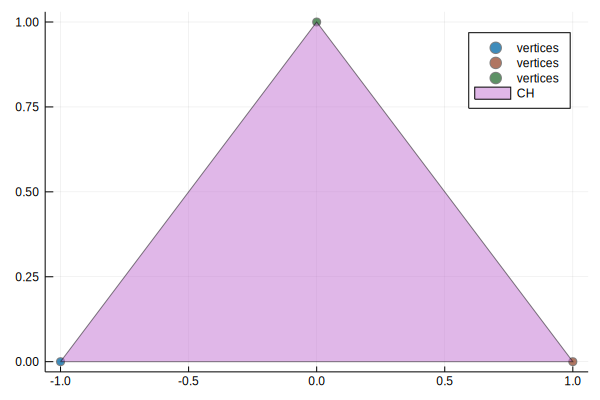

In [46]:
plot([a, b, c], lab="vertices")
plot!(Δ, lab="CH")

The area of this triangle is 1.0.

In [49]:
convert(VPolytope, Δ)

VPolytope{Float64}(Array{Float64,1}[[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])

In [50]:
vertices_list(Δ)

3-element Array{Array{Float64,1},1}:
 [-1.0, 0.0]
 [1.0, 0.0] 
 [0.0, 1.0] 

In [51]:
H = overapproximate(Δ, Hyperrectangle)
Δ = convert(HPolytope, convert(VPolytope, Δ)) # we do these conversion to speed up the computation
# we found open issues for handling  lazy minkowski sums of singletons
# see LazySets#1811, LazySets#1813, LazySets#1814
issubset(H, Δ, algorithm="vertices")

false

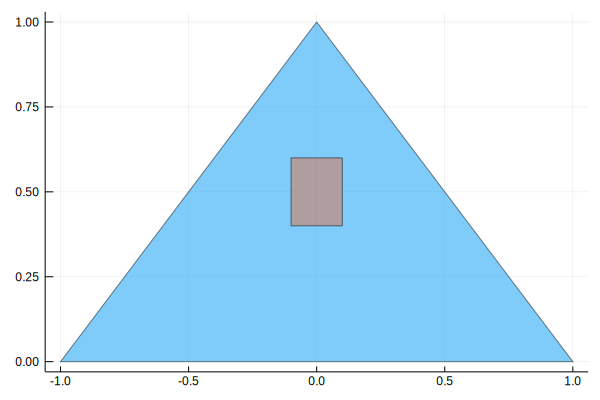

In [56]:
plot(Δ)
B = BallInf([0.0, 0.5], 0.1)
plot!(B)

In [59]:
@btime issubset($B, $Δ, algorithm="vertices")

  1.316 μs (31 allocations: 1.05 KiB)


true

In [60]:
@btime issubset($B, $Δ, algorithm="constraints")

  288.233 ns (6 allocations: 96 bytes)


true

In [55]:
@btime issubset($H, $Δ, algorithm="constraints")

  247.272 ns (4 allocations: 64 bytes)


false

In [210]:
@btime issubset($H, $Δ, algorithm="vertices")

  536.830 ns (13 allocations: 784 bytes)


false

In [211]:
@btime _volume($Δ, itermax=3, inclusion_check_algorithm="vertices")

  1.444 ms (10874 allocations: 690.94 KiB)


1.4375

In [212]:
@btime _volume($Δ, itermax=3, inclusion_check_algorithm="constraints")

  1.412 ms (10289 allocations: 645.23 KiB)


1.4375

In [64]:
[@time _volume(Δ, itermax=k, inclusion_check_algorithm="constraints") for k in 1:10]

  0.000260 seconds (854 allocations: 54.531 KiB)
  0.000628 seconds (2.99 k allocations: 187.656 KiB)
  0.002542 seconds (10.37 k allocations: 646.469 KiB)
  0.007049 seconds (34.83 k allocations: 2.123 MiB)
  0.037915 seconds (119.97 k allocations: 7.338 MiB)
  0.228186 seconds (432.43 k allocations: 26.537 MiB, 63.32% gc time)
  0.337775 seconds (1.62 M allocations: 100.072 MiB, 7.05% gc time)
  1.440354 seconds (6.27 M allocations: 385.692 MiB, 9.64% gc time)
 11.058808 seconds (24.60 M allocations: 1.477 GiB, 9.49% gc time)


InterruptException: InterruptException:

In [65]:
[@time _volume(Δ, itermax=k, inclusion_check_algorithm="vertices") for k in 1:10]

  0.000360 seconds (899 allocations: 58.047 KiB)
  0.000990 seconds (3.16 k allocations: 201.016 KiB)
  0.002309 seconds (10.95 k allocations: 692.172 KiB)
  0.008279 seconds (36.84 k allocations: 2.276 MiB)
  0.145610 seconds (127.14 k allocations: 7.885 MiB, 75.56% gc time)
  0.218565 seconds (459.19 k allocations: 28.631 MiB, 52.58% gc time)
  0.418226 seconds (1.73 M allocations: 107.911 MiB, 11.29% gc time)
  2.520664 seconds (6.67 M allocations: 416.381 MiB, 13.32% gc time)
 13.975134 seconds (26.19 M allocations: 1.595 GiB, 10.61% gc time)
148.763618 seconds (103.77 M allocations: 6.321 GiB, 4.97% gc time)


10-element Array{Float64,1}:
 2.0               
 1.75              
 1.4375            
 1.234375          
 1.12109375        
 1.0615234375      
 1.031005859375    
 1.01556396484375  
 1.0077972412109375
 1.0039024353027344

In [48]:
# this is now LazySets#1814
function LazySets.vertices_list(Δ::ConvexHullArray{N, Singleton{N, VT}}) where {N, VT}
    m = length(Δ.array)
    vertices = Vector{VT}(undef, m)
    @inbounds for i in 1:m
        vertices[i] = Δ.array[i].element
    end
    return vertices
end

function LazySets.convert(::Type{VPolytope}, Δ::ConvexHullArray{N, Singleton{N, VT}}) where {N, VT}
    return VPolytope(vertices_list(Δ))
end

In [9]:
vertices_list(Δ)

3-element Array{Array{Float64,1},1}:
 [-1.0, 0.0]
 [1.0, 0.0] 
 [0.0, 1.0] 

### Changing the disjointness check

In [239]:
@time _volume(Δ, itermax=8, inclusion_check_algorithm="constraints", disjointness_check_algorithm="exact")

  1.664848 seconds (6.27 M allocations: 385.692 MiB, 17.19% gc time)


1.01556396484375

In [241]:
# gives wrong results
@time _volume(Δ, itermax=8, inclusion_check_algorithm="constraints", disjointness_check_algorithm="sufficient")

  7.426426 seconds (27.26 M allocations: 1.692 GiB, 10.52% gc time)


2.0

## Using Branch and Prune

In [1]:
using Revise, LazySets, Plots, BranchAndPrune, Polyhedra

In [23]:
# en vez de Interval utilizo BallInf

# search the zero of a monotonic function
struct VolumeSearch <: AbstractDepthFirstSearch{Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}}
    X::LazySet
    initial::Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}
    tol::Float64
    n::Int
end

unos(n) = fill(1, n)

function BranchAndPrune.bisect(V::VolumeSearch, box)
    r = radius_hyperrectangle(box)
    _, ind = findmax(r)
    partition = unos(V.n)
    partition[ind] = 2
    B1, B2 = split(box, partition)
    #Bleft, Bright = split(box, [1, 2])
    #(a, b, c, d) = split(box, [2, 2])
    #return a, b, c, d
    return B1, B2
end

In [76]:
fill(1.0, 2)

2-element Array{Float64,1}:
 1.0
 1.0

In [68]:
x = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([2.0269010720204887, 0.6470634514280214], [0.684686733771709, 1.2445178398569277])

In [72]:
r = radius_hyperrectangle(x)

2-element Array{Float64,1}:
 0.684686733771709 
 1.2445178398569277

In [74]:
_, dir = findmax(r)

(1.2445178398569277, 2)

In [75]:
dir

2

In [191]:
function BranchAndPrune.process(search::VolumeSearch, box)
    
    #if LazySets._leq(radius(box), search.tol)
    # ????
    #if any(x -> LazySets._leq(x, search.tol), radius_hyperrectangle(box))
        #println("discarded this box because it is smaller than the tolerance")
        #return :discard, box
    #    return :store, box
    #end

    if is_intersection_empty(box, search.X, algorithm="exact")
        #println("discarded this box because the intersection with X is empty")
        return :discard, box
    elseif issubset(box, search.X, algorithm="vertices")
        #println("store this box")
        #search.vol += volume(box)
        #global vol += volume(box)
        #println("stored box $box")
        return :store, box
    else
        #println("bisect this box")
        #return :bisect, box
        
        #=
        if volume(box) < search.tol
            #println("discarded this box because it is smaller than the tolerance")
            return :store, box # la agrego al volumen asi me da una cota superior
        elseif interseccion_puntual(search.X, box)
            return :discard, box
        else
            return :bisect, box
        end
        =#
        
        if interseccion_puntual(search.X, box)
            return :discard, box
        elseif volume(box) < search.tol
            return :store, box
        else
            return :bisect, box
        end
    end
        
    end
    #println(" - - - ")
end

LoadError: syntax: unexpected "end"

In [192]:
function find_covering(X; tol=1.0)

    initial_box = overapproximate(X, Hyperrectangle)
    search = VolumeSearch(X, initial_box, tol, LazySets.dim(X))

    local endtree = nothing
    niter = 0
    aux = []
    
    for wt in search
        working_leaves_idx = wt.working_leaves
        nodes_working = [wt.leaves[i] for i in working_leaves_idx]
        push!(aux, nodes_working)
        #print("$nodes_working")
        #println(" - - - - ")
        endtree = wt
        niter += 1
    end

    println("Search finished in $niter iterations.")
    d = data(endtree)  # Retrieve the data from the tree
    if length(d) == 0
        println("The covering is empty.")
    else
        # If there is a zero, the tree will have only one data available
        z = d[1]
        println("The covering is non-empty with data $(length(d))")
    end
    return d, aux
end

find_covering (generic function with 1 method)

### (Sanity check) Test with hyperrectangular set

In [6]:
R = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.4819837090074565, -0.4016412651362022], [0.04289548733976159, 0.551187994870679])

In [48]:
find_covering(R, tol=1e-3)

0
Search finished in 1 iterations.
The covering is non-empty with data 1


1-element Array{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},1}:
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.4819837090074565, -0.4016412651362022], [0.04289548733976159, 0.551187994870679])

### Test with triangle shape

In [127]:
a = [-1.0, 0.0]
b = [1.0, 0.0]
c = [0.0, 1.0]
Δ = VPolytope([a, b, c])

VPolytope{Float64}(Array{Float64,1}[[-1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])

In [50]:
find_covering(Δ, tol=10.0)

0
Search finished in 1 iterations.
The covering is empty.


0-element Array{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},1}

In [200]:
d, aux = find_covering(Δ, tol=0.00001);

Search finished in 4087 iterations.
The covering is non-empty with data 1534


In [129]:
aux[1]

2-element Array{BranchAndPrune.BPLeaf{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}:
 Leaf (:working) with data Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.5, 0.5], [0.5, 0.5])
 Leaf (:working) with data Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.5, 0.5], [0.5, 0.5]) 

In [184]:
Z = [x.data for x in aux[1]]

2-element Array{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},1}:
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.5, 0.5], [0.5, 0.5])
 Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.5, 0.5], [0.5, 0.5]) 

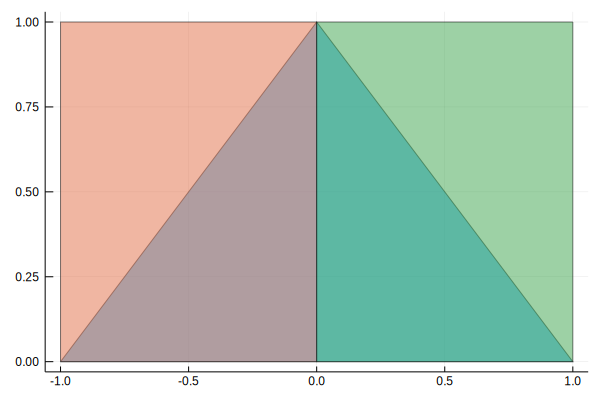

In [131]:
plot(Δ)
plot!(Z)

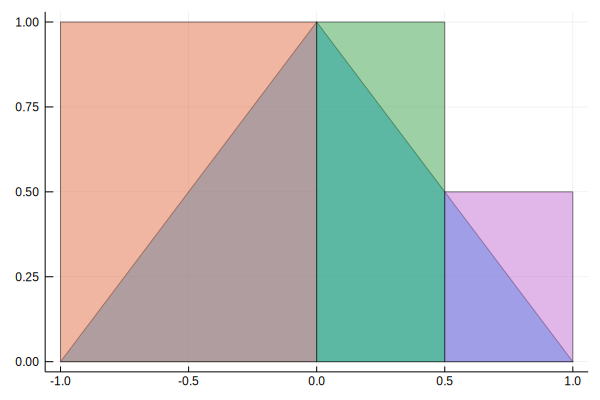

In [189]:
Z = [x.data for x in aux[4]]
plot(Δ)
plot!(Z)

In [201]:
mapreduce(x -> volume(x), +, d)

1.00390625

In [195]:
volume(rand(Hyperrectangle))

1.6156442617723445

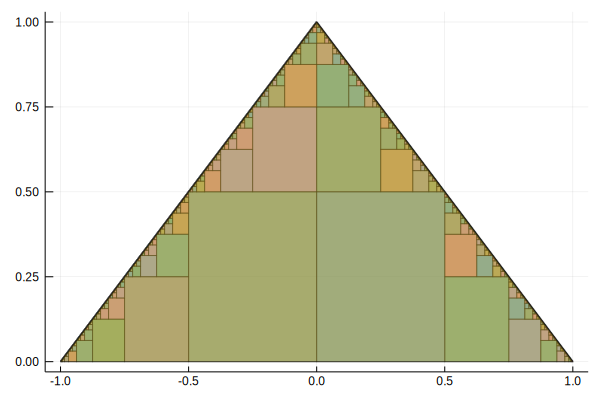

In [202]:
plot([x for x in d])
plot!(Δ)

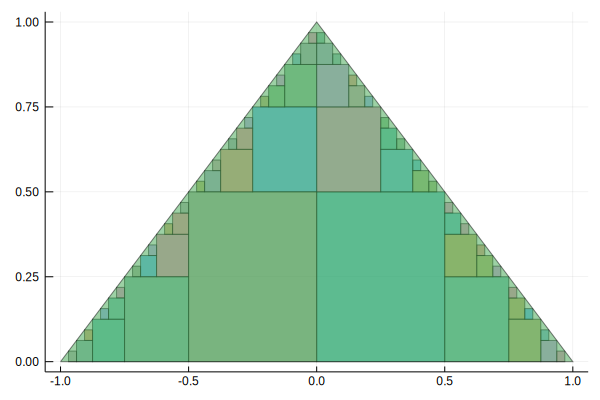

In [33]:
plot([x for x in d])
plot!(Δ)

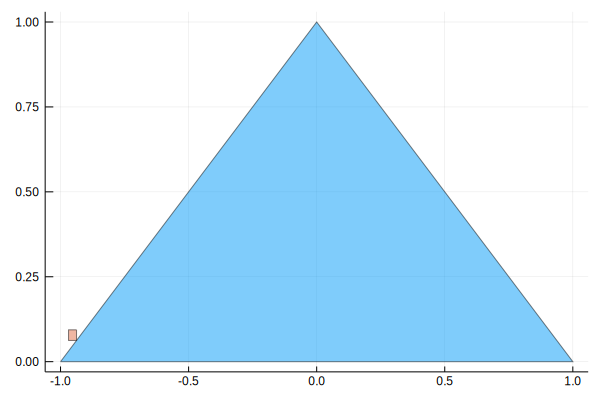

In [149]:
plot(Δ)
#plot!([d[i] for i in 1:7])
plot!(d[7])

In [150]:
x = d[7]

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.953125, 0.078125], [0.015625, 0.015625])

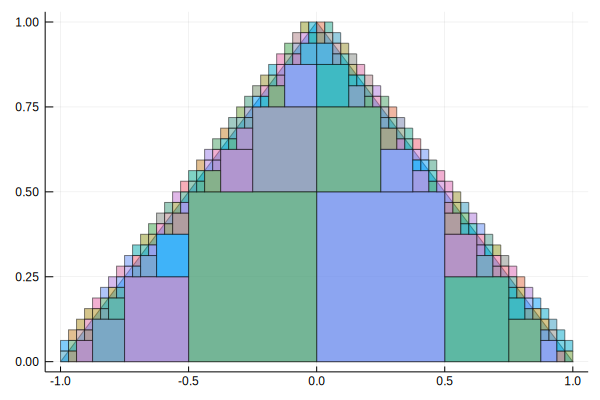

In [179]:
plot(Δ)
plot!(d)

In [153]:
is_intersection_empty(x, Δ)

false

In [155]:
issubset(x, Δ)

false

In [156]:
@which is_intersection_empty(x, Δ)

is_intersection_empty(P::AbstractPolyhedron{N}, Q::AbstractPolyhedron{N}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/ConcreteOperations/isdisjoint.jl:986

In [162]:
p = intersection(x, Δ)

HPolytope{Float64}(LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[LazySets.HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0, 0.0], -0.9375), LazySets.HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([0.0, -1.0], -0.0625), LazySets.HalfSpace{Float64,Array{Float64,1}}([-0.3333333333333333, 0.3333333333333333], 0.3333333333333333)])

In [165]:
constraints_list(p)

3-element Array{LazySets.HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 LazySets.HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0, 0.0], -0.9375)                
 LazySets.HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([0.0, -1.0], -0.0625)               
 LazySets.HalfSpace{Float64,Array{Float64,1}}([-0.3333333333333333, 0.3333333333333333], 0.3333333333333333)

In [166]:
vertices_list(p)

1-element Array{Array{Float64,1},1}:
 [-0.9375, 0.062499999999999944]

In [171]:
interseccion_puntual(A, B) = length(vertices_list(intersection(A, B))) == 1

interseccion_puntual (generic function with 1 method)

In [177]:
exteriores = filter(di -> interseccion_puntual(Δ, di), d);

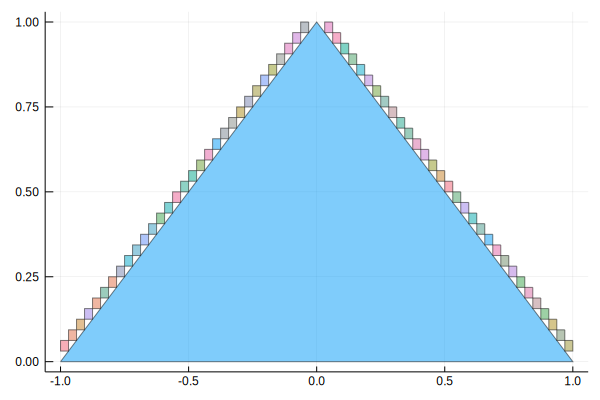

In [178]:
plot(Δ)
plot!(exteriores)

In [173]:
[interseccion_puntual(Δ, d[i]) for i in 1:length(d)]

188-element Array{Bool,1}:
 0
 0
 0
 0
 0
 0
 1
 0
 0
 1
 0
 1
 0
 ⋮
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0